## Object Detection with Fast.ai and IceVision

Initial experiments training FasterRCNN (object detection) with Forensic Architecture's synthetic datasets. 

In [ ]:
from fastbook import *
# from fastai.vision.widgets import *
from IPython.display import Image
import matplotlib.pyplot as plt
from icevision.all import *
# import icedata
# from PIL import Image

In [2]:
path = "TopOnly_Scatter/2019.10.22_Multiple_TopOnly_Scatter/UE4TripleChasers/"

In [3]:
source = Path(path + 'img')

In [4]:
class CanisterParser(parsers.FasterRCNN, parsers.FilepathMixin):
    def __init__(self, source):
        self.image_paths = get_image_files(source)
    
    def __iter__(self):
        yield from self.image_paths
        
    def __len__(self):
        return len(self.image_paths)
    
    def imageid(self, o) -> Hashable:
        return o
    
    def filepath(self, o) -> Union[str, Path]:
        return o 
    
    def image_width_height(self, o) -> Tuple[int, int]:
        return get_image_size(self.filepath(o))
    
    def labels(self, o) -> List[int]:
        return bbox_label_func(o)[0]
    
    def bboxes(self, o) -> List[BBox]:
        all_boxes = bbox_label_func(o)[1]
        all_bounding_boxes = []
        if len(all_boxes)<1:
          return []
        else:
          for inner_box in all_boxes:
            all_bounding_boxes.append(BBox.from_xywh(*inner_box))
        return all_bounding_boxes

We can use get_annotations() to parse bboxes and categories from json when the format is compatible... but for now I'm just doing this manually. 

In [5]:
label_map = ['background']

def bbox_label_func(fname):
    with open(str(fname).replace("/img/","/ann/").replace(fname.suffix, ".json")) as f:
        data = json.load(f)
        categories = []
        all_boxes = []
        for object in data['objects']:
            if object['points']['exterior']:
                bbox = object['points']['exterior']
                bbox = [bbox[0][0], bbox[0][1], bbox[1][0]-bbox[0][0], bbox[1][1]-bbox[0][1]]
                all_boxes.append(bbox)
                if object['classTitle'] not in label_map:
                    label_map.append(object['classTitle'])
                categories.append(label_map.index(object['classTitle']))
        return categories, all_boxes

In [6]:
parser = CanisterParser(source)

In [7]:
data_splitter = RandomSplitter([0.8,0.2])

In [8]:
train_records, valid_records = parser.parse(data_splitter)

INFO     - Autofixing records | icevision.parsers.parser:parse:124


In [9]:
# view format: 
train_records[0]

Record:
	- Image ID: 99
	- Image size (width, height): (3840, 2160)
	- Labels: [1, 1, 1, 1, 1, 1, 1, 1]
	- BBoxes: [<BBox (xmin:1589, ymin:619, xmax:1702, ymax:730)>, <BBox (xmin:2213, ymin:631, xmax:2322, ymax:756)>, <BBox (xmin:1500, ymin:652, xmax:1604, ymax:781)>, <BBox (xmin:2603, ymin:720, xmax:2715, ymax:840)>, <BBox (xmin:2309, ymin:1067, xmax:2436, ymax:1225)>, <BBox (xmin:1407, ymin:1071, xmax:1535, ymax:1229)>, <BBox (xmin:2196, ymin:1139, xmax:2355, ymax:1310)>, <BBox (xmin:1520, ymin:1160, xmax:1648, ymax:1316)>]
	- Filepath: TopOnly_Scatter/2019.10.22_Multiple_TopOnly_Scatter/UE4TripleChasers/img/0099.png

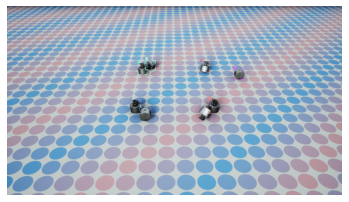

In [10]:
# bounding boxes are often too thin to be seen
show_record(train_records[0])

In [11]:
train_tfms = tfms.A.Adapter(
    [*tfms.A.aug_tfms(size=384, presize=512), tfms.A.Normalize()]
)
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=384), tfms.A.Normalize()])

In [12]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

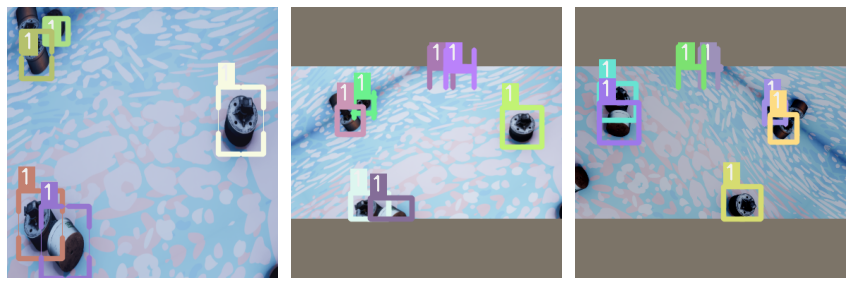

In [13]:
samples = [train_ds[9] for _ in range(3)]
show_samples(samples, denormalize_fn=denormalize_imagenet, ncols=3)

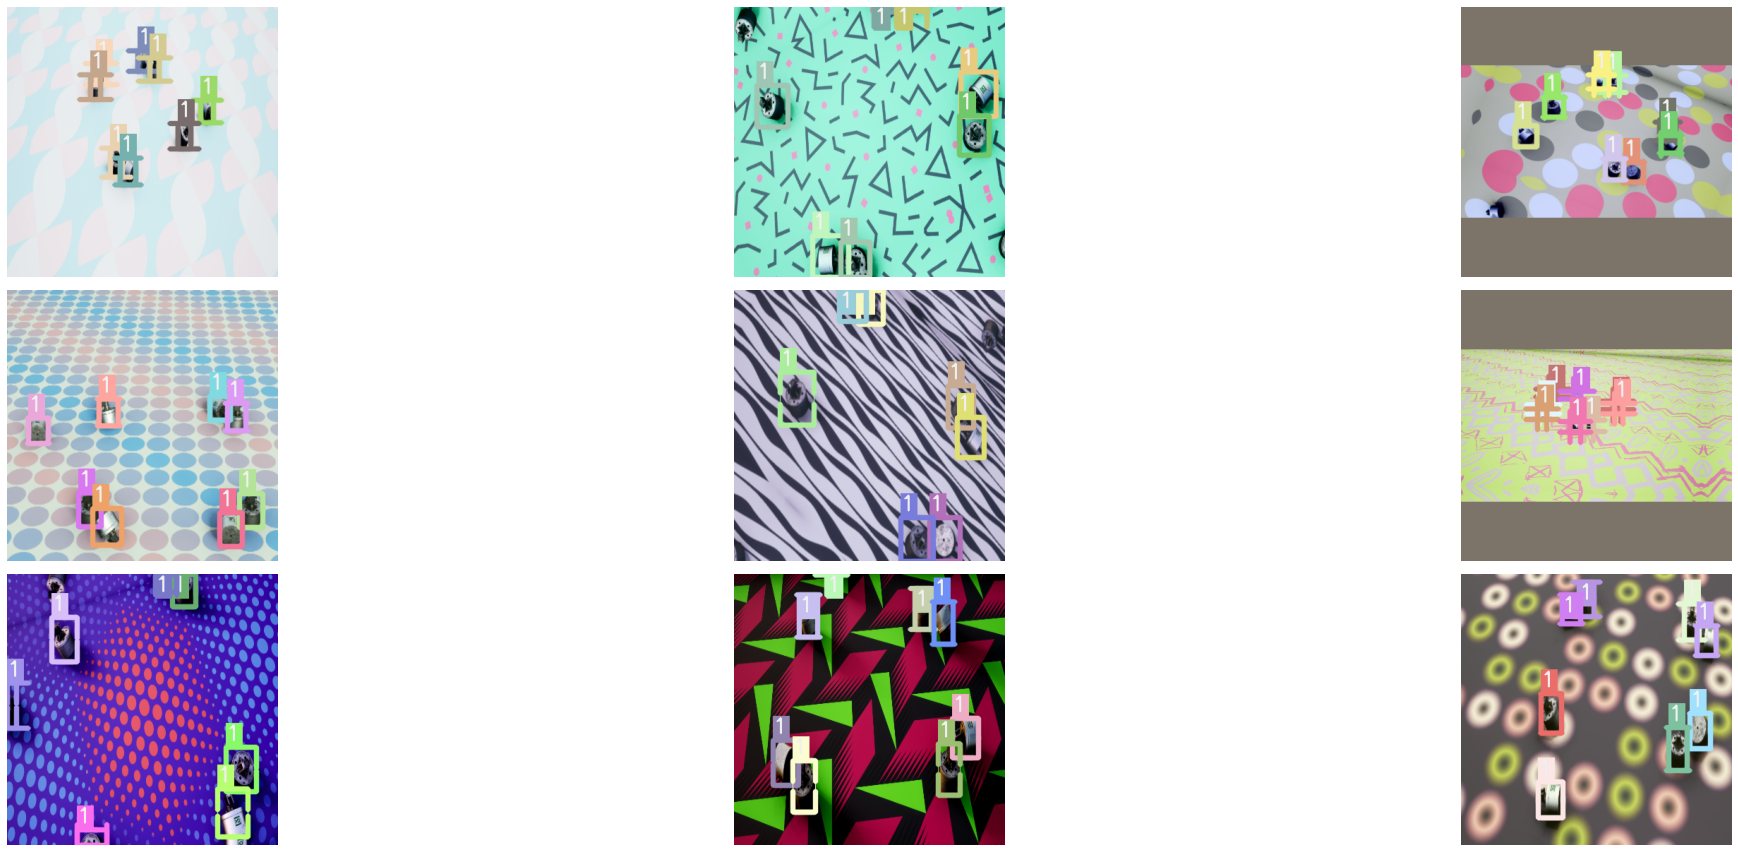

In [15]:
# should look at a better format of printing multiple images as these all come out pretty small and low quality
# not ideal for debugging
train_dl = faster_rcnn.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = faster_rcnn.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)
batch, samples = first(train_dl)
show_samples(
    samples[:9], ncols=3, denormalize_fn=denormalize_imagenet
)

In [16]:
model = faster_rcnn.model(num_classes=2)

In [17]:
metrics = [COCOMetric()]

In [18]:
learn = faster_rcnn.fastai.learner(
    dls=[train_dl, valid_dl], model=model, metrics=metrics, detection_threshold = 0.96)

SuggestedLRs(lr_min=0.0001737800776027143, lr_steep=7.585775847473997e-07)

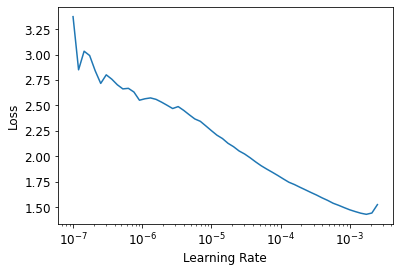

In [19]:
learn.lr_find()

In [20]:
learn.fit_one_cycle(10, 1e-4)

epoch,train_loss,valid_loss,COCOMetric,time
0,2.357606,1.433637,0.044997,00:18
1,1.750362,1.084129,0.192800,00:17
2,1.490472,0.999863,0.244775,00:17
3,1.290181,0.890189,0.206668,00:19
4,1.165705,0.793564,0.357498,00:18
5,1.073759,0.800132,0.275044,00:18
6,1.000883,0.771131,0.323678,00:18
7,0.941844,0.737469,0.391327,00:18
8,0.895225,0.729450,0.403762,00:19
9,0.856260,0.723511,0.410123,00:18


Our visualisation options on first glance seem a bit limited for debugging our training dataset. In fastai we can create an Interpretation object from our learner from which we can find our top_losses. Interpretation doesn't seem to be compatible with the learner that we create with Icevision: 

In [25]:
Interpretation.from_learner(learn)

AssertionError: 

We can create an Interpretation object without providing a learner (see Interpretation??) and I'm currently working out if we can get around this. Otherwise we can use show_results to visualise our model's predictions on a limited number of images.

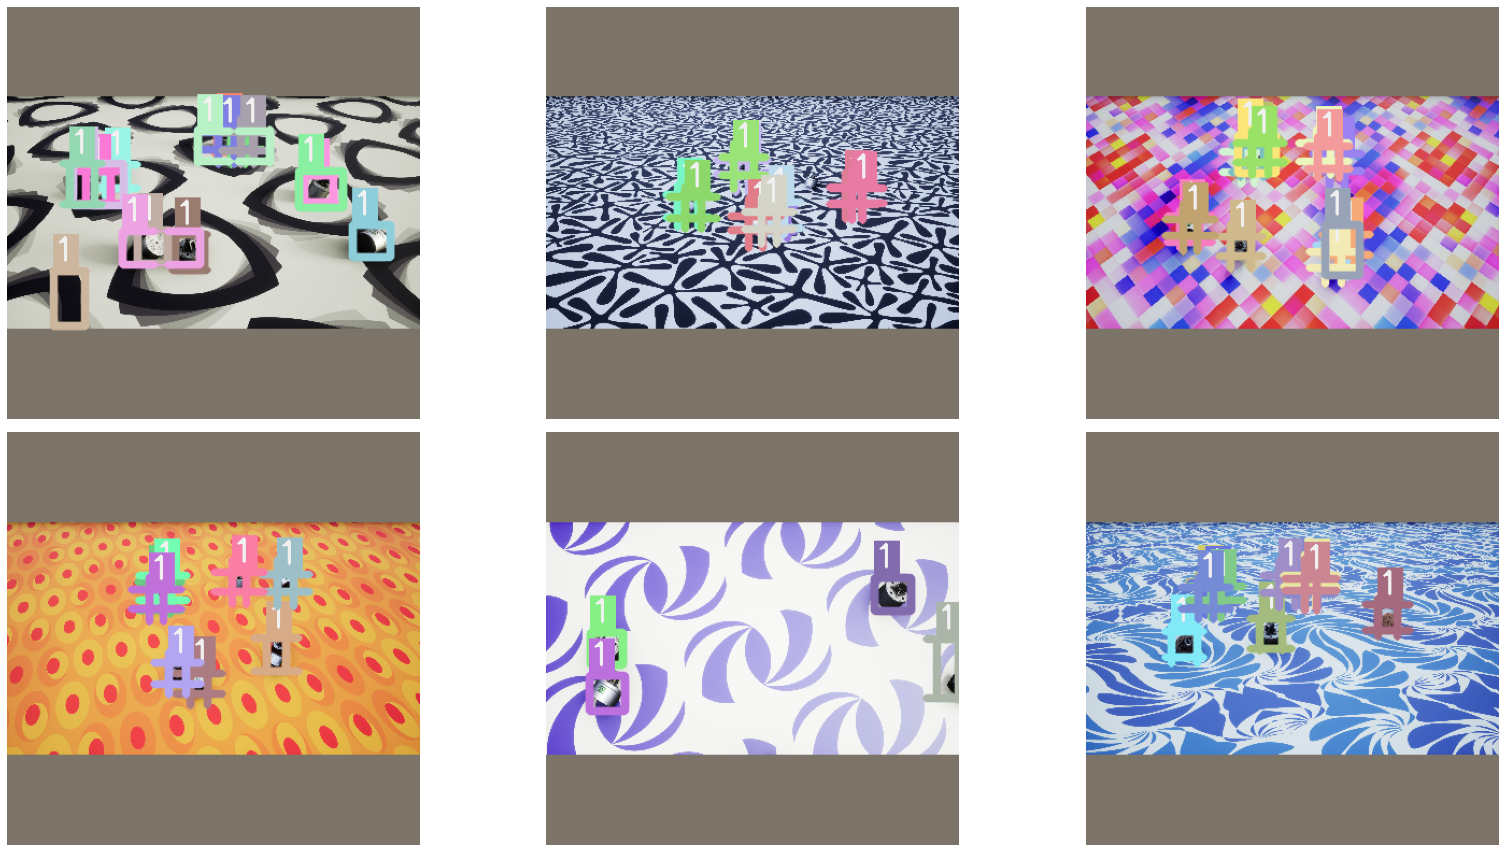

In [24]:
faster_rcnn.show_results(model, valid_ds, ncols=3, num_samples= 6)